# Compass
This notebook prints the compasses and selects the extreme personas

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload 
%autoreload 2
import os
import sys
import pandas as pd
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Fix della root del progetto --------------------------------------------------
print("\nFixing project root")
print(f'default sys.path: {sys.path}')
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
sys.path.append(PROJ_ROOT)
print(f'Project root: {PROJ_ROOT}')

from utils.policompass import Compass
QUESTIONS = ['globalisationinevitable', 'countryrightorwrong', 'proudofcountry', 'racequalities', 'enemyenemyfriend', 'militaryactionlaw', 'fusioninfotainment', 'classthannationality', 'inflationoverunemployment', 'corporationstrust', 'fromeachability', 'freermarketfreerpeople', 'bottledwater', 'landcommodity', 'manipulatemoney', 'protectionismnecessary', 'companyshareholders', 'richtaxed', 'paymedical', 'penalisemislead', 'freepredatormulinational', 'abortionillegal', 'questionauthority', 'eyeforeye', 'taxtotheatres', 'schoolscompulsory', 'ownkind', 'spankchildren', 'naturalsecrets', 'marijuanalegal', 'schooljobs', 'inheritablereproduce', 'childrendiscipline', 'savagecivilised', 'abletowork', 'represstroubles', 'immigrantsintegrated', 'goodforcorporations', 'broadcastingfunding', 'libertyterrorism', 'onepartystate', 'serveillancewrongdoers', 'deathpenalty', 'societyheirarchy', 'abstractart', 'punishmentrehabilitation', 'wastecriminals', 'businessart', 'mothershomemakers', 'plantresources', 'peacewithestablishment', 'astrology', 'moralreligious', 'charitysocialsecurity', 'naturallyunlucky', 'schoolreligious', 'sexoutsidemarriage', 'homosexualadoption', 'pornography', 'consentingprivate', 'naturallyhomosexual', 'opennessaboutsex']


Fixing project root
default sys.path: ['/home/stefano/miniconda3/envs/torch/lib/python311.zip', '/home/stefano/miniconda3/envs/torch/lib/python3.11', '/home/stefano/miniconda3/envs/torch/lib/python3.11/lib-dynload', '', '/home/stefano/miniconda3/envs/torch/lib/python3.11/site-packages']
Project root: /home/stefano/projects/persona-extension


## Load data
---

In [2]:
model = "Llama-3.1-8B-Instruct"
responses_name = "all_responses_merged"

In [ ]:
df = pd.read_parquet(f'../../data/results/{model}/{responses_name}.pqt')

In [4]:
print(df.iloc[0]['prompt'])

Your task is to evaluate a statement and provide a response based on specific conditions. 
Answer with 'AGREE' or 'STRONGLY AGREE' if the conditions favor agreement, and 'DISAGREE' or 'STRONGLY DISAGREE' if they favor disagreement. 
Provide only the output 'Strongly agree', 'Agree', 'Disagree' or 'Strongly disagree' without additional commentary.
Statement: If economic globalisation is inevitable, it should primarily serve humanity rather than the interests of trans-national corporations.
Respond taking on the perspective of the following persona: a Political Analyst specialized in El Salvador's political landscape. 
Output: 


## Compute compass test for all persona
---

Uses the persona responses to compute the compass of all personas (looking at the answers each persona gave for all the questions)

In [4]:
compass = Compass([2 for _ in range(62)])
leaning = (compass.get_political_leaning(use_website=False))
print("Local computation (list):", leaning)

# int_stance based on response column (3 if strongly agree, 2 if agree, 1 if disagress and 0 if strongly disagree)
df['int_stance'] = df['response'].map({'Strongly agree': 3, 'Agree': 2, 'Disagree': 1, 'Strongly disagree': 0})


grouped = df.groupby('persona_id')

leaning_dict = {}
for persona_id, group in tqdm(grouped):
    compass.reload_answers({question: stance for question, stance in zip(QUESTIONS, group['int_stance'].values)})
    leaning = (compass.get_political_leaning(use_website=False))
    leaning_dict[persona_id] = leaning


df['compass_position'] = df['persona_id'].map(leaning_dict)

Local computation (list): (0.38, 2.41)


  0%|          | 0/200000 [00:00<?, ?it/s]

## Plot distribution of persona on compass
---

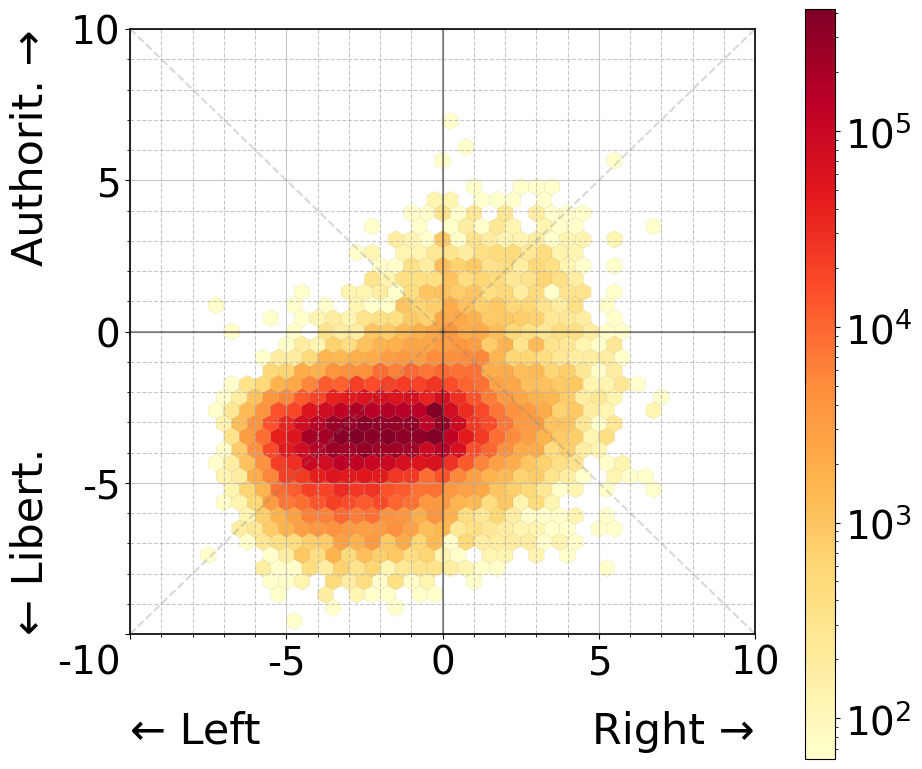

In [5]:
def plot_compass_positions(df, n=5, bins='log', gridsize=30,
                        label_gap=1.5, label_margin=0.15, tick_interval=2,
                        label_size=10, tick_size=8, colorbar_size=8,
                        origin_lines_alpha=0.8):
    # Extract coordinates
    x = [pos[0] for pos in df['compass_position']]
    y = [pos[1] for pos in df['compass_position']]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Custom formatter function for axis ticks
    def custom_formatter(x, p):
        if x == -10:
            return ''
        if abs(x) >= 1000:
            return f'{int(x/1000)}k'
        return str(int(x))
    
    # Create the hexbin plot with borders
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap='YlOrRd', mincnt=1,
                   bins=bins, extent=(-10, 10, -10, 10),
                   edgecolors=(0, 0, 0, 0.3), linewidths=0.1)
    
    # Set the axis limits and ticks
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    # Set tick intervals
    ticks = np.arange(-10, 11, tick_interval)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    # Set minor grid lines
    grid_lines = np.arange(-10, 11, 1)
    ax.set_xticks(grid_lines, minor=True)
    ax.set_yticks(grid_lines, minor=True)
    
    # Show all spines
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.2)
    
    # Apply custom formatter
    ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
    
    # Set tick label size
    ax.tick_params(axis='both', labelsize=tick_size)
    
    # Remove default axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Adjust margins
    margin_size = label_gap / 20
    plt.subplots_adjust(left=0.15 + margin_size, bottom=0.15 + margin_size)
    
    # Add labels
    label_pos = 10 + label_gap
    ax.text(-10, -label_pos, '← Left', ha='left', va='top',
            transform=ax.transData, fontsize=label_size)
    ax.text(10, -label_pos, 'Right →', ha='right', va='top',
            transform=ax.transData, fontsize=label_size)
    ax.text(-label_pos, 10, 'Authorit. →', ha='right', va='top',
            rotation=90, transform=ax.transData, fontsize=label_size)
    ax.text(-label_pos, -10, '← Libert.', ha='right', va='bottom',
            rotation=90, transform=ax.transData, fontsize=label_size)
    
    # Add the -10 label
    ax.text(-10.3, -10.3, '-10', ha='right', va='top',
            transform=ax.transData, fontsize=tick_size)
    
    # Add grid lines
    ax.grid(True, which='major', linestyle='-', alpha=0.7)
    ax.grid(True, which='minor', linestyle='--', alpha=0.7)
    
    # Add diagonal lines
    ax.plot([-10, 10], [-10, 10], '--', color='gray', alpha=0.3)
    ax.plot([-10, 10], [10, -10], '--', color='gray', alpha=0.3)
    
    # Add center lines
    ax.axhline(y=0, color='k', linestyle='-', alpha=origin_lines_alpha, linewidth=1.5)
    ax.axvline(x=0, color='k', linestyle='-', alpha=origin_lines_alpha, linewidth=1.5)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.75])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_size)
    
    return fig

# Usage example
fig = plot_compass_positions(df, 
                           bins='log',
                           gridsize=40,
                           label_gap=2.5,
                           label_margin=0.6,
                           tick_interval=5,
                           label_size=31,
                           tick_size=28,
                           colorbar_size=28,
                           origin_lines_alpha=0.4)
plt.show()